# Citations Analysis using Embeddings

Initialize ChromaDB

In [1]:
import chromadb

from config import DATA_DIR

In [2]:
chroma_db_path = DATA_DIR.joinpath("chroma").resolve()

chroma = chromadb.PersistentClient(path=str(chroma_db_path))
embeddings = chroma.get_or_create_collection("analysis")

## Load Data

In [3]:
from buff.openalex import Work
from buff.openalex.download import get_paper_text
from buff.llm.utils import get_token_count

## Papers

**Paper 2 - Cites - Paper 1**
$\text{Paper 2} \rightarrow \text{Paper 1}$

In [4]:
paper_1 = "W2994792393"
paper_2 = "W3190631166"

In [5]:
work_1 = await Work(paper_1).data
work_2 = await Work(paper_2).data

In [6]:
print("Paper 1: ", work_1.title)
print("Paper 2: ", work_2.title)

Paper 1:  The autophagy receptor p62/SQST-1 promotes proteostasis and longevity in C. elegans by inducing autophagy
Paper 2:  Autophagy in healthy aging and disease


In [7]:
text_1 = await get_paper_text(work=work_1)
text_2 = await get_paper_text(work=work_2)

print(f"Paper 1 loaded: {get_token_count(text_1)} tokens")
print(f"Paper 2 loaded: {get_token_count(text_2)} tokens")

Paper 1 loaded: 22380 tokens
Paper 2 loaded: 32836 tokens


## Text Processing

In [8]:
# from buff.llm.split import split_text
# 
# text_1_chunks = split_text(text_1)
# text_2_chunks = split_text(text_2)
# 
# # Save the chunks
# with open("chunks.json", "w", encoding="utf-8") as f:
#     f.write(json.dumps({
#         "paper_1": text_1_chunks,
#         "paper_2": text_2_chunks
#     }))
#     print("Chunks saved")

In [9]:
import json

# Load the chunks
with open("chunks.json", "r", encoding="utf-8") as f:
    text_chunks = json.load(f)
    text_1_chunks = text_chunks["paper_1"]
    text_2_chunks = text_chunks["paper_2"]
    print("Chunks loaded")

print(f"Paper 1 split into {len(text_1_chunks)} chunks")
print(f"Paper 2 split into {len(text_2_chunks)} chunks")

Chunks loaded
Paper 1 split into 42 chunks
Paper 2 split into 66 chunks


Print min-mean-max token count for each chunk

In [10]:
text_1_chunks_tokens = [get_token_count(chunk) for chunk in text_1_chunks]
text_2_chunks_tokens = [get_token_count(chunk) for chunk in text_2_chunks]

print(
    f"Paper 1 chunk stats: {min(text_1_chunks_tokens)} - {sum(text_1_chunks_tokens) // len(text_1_chunks_tokens)} - {max(text_1_chunks_tokens)}")
print(
    f"Paper 2 chunk stats: {min(text_2_chunks_tokens)} - {sum(text_2_chunks_tokens) // len(text_2_chunks_tokens)} - {max(text_2_chunks_tokens)}")

Paper 1 chunk stats: 267 - 532 - 815
Paper 2 chunk stats: 81 - 497 - 684


### Embeddings

In [11]:
# from buff.llm.embed import embed_texts
# 
# text_1_embeddings = await embed_texts(text_1_chunks)
# text_2_embeddings = await embed_texts(text_2_chunks)
# 
# # Save the embeddings
# with open("embeddings.json", "w", encoding="utf-8") as f:
#     f.write(json.dumps({
#         "paper_1": text_1_embeddings,
#         "paper_2": text_2_embeddings
#     }))
#     print("Embeddings saved")

# Load the embeddings
with open("embeddings.json", "r", encoding="utf-8") as f:
    text_embeddings = json.load(f)
    text_1_embeddings = text_embeddings["paper_1"]
    text_2_embeddings = text_embeddings["paper_2"]
    print("Embeddings loaded")

print(f"Paper 1 embedded into {len(text_1_embeddings)} chunks")
print(f"Paper 2 embedded into {len(text_2_embeddings)} chunks")

Embeddings loaded
Paper 1 embedded into 42 chunks
Paper 2 embedded into 66 chunks


Store the documents

In [12]:
# from buff.llm.models import Document, DocumentMetadata
# 
# # Build the documents
# text_1_documents = [
#     Document(
#         metadata=DocumentMetadata(
#             index=i,
#             work_id=str(work_1.id),
#             doi=str(work_1.doi),
#             text=text_1_chunks[i]
#         ),
#         id=f"{work_1.id}-{i}",
#         values=text_1_embeddings[i]
#     )
#     for i in range(len(text_1_chunks))
# ]
# 
# text_2_documents = [
#     Document(
#         metadata=DocumentMetadata(
#             index=i,
#             work_id=str(work_2.id),
#             doi=str(work_2.doi),
#             text=text_2_chunks[i]
#         ),
#         id=f"{work_2.id}-{i}",
#         values=text_2_embeddings[i]
#     )
#     for i in range(len(text_2_chunks))
# ]
# print(f"Paper 1: {len(text_1_documents)} documents")
# print(f"Paper 2: {len(text_2_documents)} documents")
# 
# 
# # Create the following lists of data from the 2 documents arrays
# text_chunk_ids = [doc.id for doc in text_1_documents + text_2_documents]
# text_chunk_embeddings = [doc.values for doc in text_1_documents + text_2_documents]
# text_chunk_metadata = [doc.metadata.model_dump(mode="json") for doc in text_1_documents + text_2_documents]
# print(f"Total: {len(text_chunk_ids)} documents.")
# if not len(text_chunk_embeddings) == len(text_chunk_metadata) == len(text_chunk_ids):
#     raise ValueError("Invalid data")
# 
# # Store the embeddings
# embeddings.add(
#     ids=text_chunk_ids,
#     embeddings=text_chunk_embeddings,
#     metadatas=text_chunk_metadata
# )
# print("Embeddings stored")

In [13]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
# Convert the lists to numpy arrays
text_1_vecs = np.array(text_1_embeddings)
text_2_vecs = np.array(text_2_embeddings)

text_vecs_offset = 3

# Ignore the first and last few vectors from each array
text_1_vecs = text_1_vecs[text_vecs_offset:-text_vecs_offset]
text_2_vecs = text_2_vecs[text_vecs_offset:-text_vecs_offset]

In [15]:
# Calculate the cosine similarity matrix
similarity_matrix = cosine_similarity(text_1_vecs, text_2_vecs)

In [16]:
# Find the indices of the 10 most common embeddings
most_common_indices = np.unravel_index(similarity_matrix.argpartition(-10, axis=None)[-10:], similarity_matrix.shape)

# Find the indices of the 10 most different embeddings
most_different_indices = np.unravel_index(similarity_matrix.argpartition(10, axis=None)[:10], similarity_matrix.shape)

# Sort the most common indices based on similarity scores in descending order
most_common_scores = similarity_matrix[most_common_indices]
most_common_sorted_indices = np.argsort(-most_common_scores)
most_common_indices = (most_common_indices[0][most_common_sorted_indices], most_common_indices[1][most_common_sorted_indices])

# Sort the most different indices based on similarity scores in ascending order
most_different_scores = similarity_matrix[most_different_indices]
most_different_sorted_indices = np.argsort(most_different_scores)
most_different_indices = (most_different_indices[0][most_different_sorted_indices], most_different_indices[1][most_different_sorted_indices])

# Print the index pairs and similarity scores for the most common embeddings in descending order
print("10 most common embeddings (in descending order of similarity):")
for i in range(10):
    index_1, index_2 = most_common_indices[0][i], most_common_indices[1][i]
    similarity_score = similarity_matrix[index_1, index_2]
    print(f"Index pair: ({index_1 + text_vecs_offset}, {index_2 + text_vecs_offset}), Similarity score: {similarity_score:.4f}")

# Print the index pairs and similarity scores for the most different embeddings in ascending order
print("\n10 most different embeddings (in ascending order of similarity):")
for i in range(10):
    index_1, index_2 = most_different_indices[0][i], most_different_indices[1][i]
    similarity_score = similarity_matrix[index_1, index_2]
    print(f"Index pair: ({index_1 + text_vecs_offset}, {index_2 + text_vecs_offset}), Similarity score: {similarity_score:.4f}")

10 most common embeddings (in descending order of similarity):
Index pair: (38, 48), Similarity score: 0.8527
Index pair: (38, 46), Similarity score: 0.8487
Index pair: (34, 45), Similarity score: 0.8380
Index pair: (38, 47), Similarity score: 0.8371
Index pair: (38, 62), Similarity score: 0.8338
Index pair: (34, 49), Similarity score: 0.8319
Index pair: (37, 48), Similarity score: 0.8310
Index pair: (36, 47), Similarity score: 0.8282
Index pair: (36, 48), Similarity score: 0.8268
Index pair: (36, 46), Similarity score: 0.8259

10 most different embeddings (in ascending order of similarity):
Index pair: (14, 13), Similarity score: 0.2403
Index pair: (13, 13), Similarity score: 0.2470
Index pair: (13, 56), Similarity score: 0.2544
Index pair: (13, 27), Similarity score: 0.2588
Index pair: (13, 23), Similarity score: 0.2668
Index pair: (15, 56), Similarity score: 0.2676
Index pair: (15, 13), Similarity score: 0.2693
Index pair: (13, 32), Similarity score: 0.2735
Index pair: (33, 23), Sim

In [17]:
# Print the text chunks for the most common embeddings
print("\n10 most common text chunks:")
for i in range(10):
    index_1, index_2 = most_common_indices[0][i], most_common_indices[1][i]
    print(f"\nText 1 chunk: {text_1_chunks[index_1 + text_vecs_offset]}")
    print(f"\nText 2 chunk: {text_2_chunks[index_2 + text_vecs_offset]}")
    print("-"*64 + "\n\n\n")


10 most common text chunks:

Text 1 chunk: Integrating the stress response: lessons for neurodegenerative diseases from C. elegans. Trends Cell Biol. 19, 52–61 (2009). 47. Ben-Zvi, A., Miller, E. A. & Morimoto, R. I. Collapse of proteostasis represents an early molecular event in Caenorhabditis elegans aging. Proc. Natl Acad. Sci. USA 106, 14914–14919 (2009). 48. Vilchez, D. et al. RPN-6 determines C. elegans longevity under proteotoxic stress conditions. Nature 489, 263–268 (2012). 49. Sun, T., Wang, X., Lu, Q., Ren, H. & Zhang, H. CUP-5, the C. elegans ortholog of the mammalian lysosomal channel protein MLN1/TRPML1, is required for proteolytic degradation in autolysosomes. Autophagy 7, 1308–1315 (2011). 50. Wu, Y. et al. PI3P phosphatase activity is required for autophagosome maturation and autolysosome formation. EMBO Rep. 15, 973–981 (2014). 51. Toth, M. L. et al. Longevity pathways converge on autophagy genes to regulate life span in Caenorhabditis elegans. Autophagy 4, 330–338 (

In [18]:
# Print the text chunks for the most different embeddings
print("\n10 most different text chunks:")
for i in range(10):
    index_1, index_2 = most_different_indices[0][i], most_different_indices[1][i]
    print(f"\nText 1 chunk: {text_1_chunks[index_1 + text_vecs_offset]}")
    print(f"\nText 2 chunk: {text_2_chunks[index_2 + text_vecs_offset]}")
    print("-"*64 + "\n\n\n")


10 most different text chunks:

Text 1 chunk: NATURE COMMUNICATIONS | https://doi.org/10.1038/s41467-019-13540-4 ARTICLE NATURE COMMUNICATIONS | (2019) 10:5648 | https://doi.org/10.1038/s41467-019-13540-4 | www.nature.com/naturecommunications 5 100 a b c d e h f g 75 Percent alive Percent alive Percent alive Percent alive Percent alive Percent fluorescence intensity Percent fluorescence intensity Percent alive Aggregates in head 50 25 0 100 75 50 25 0 100 75 50 25 0 100 75 50 25 0 100 75 50 25 0 100 75 50 25 0 0 10 20 WT-CTRL WT-CTRL WT-HS WT-CTRL WT-HS P < 0.0001 P < 0.0001 P < 0.0001 P < 0.0001 P < 0.0001 P = 0.4 P = 0.8 P = 0.0003 P = 0.9 WT WT sqst-1 sqst-1; SQST-1 Neuronal SQST-1 OE Neuronal SQST-1 OE-CTRL Neuronal SQST-1 OE-HS Neuronal Q40 Neuronal Q40 ;SQST-1 OE SQST-1 OE-CTRL SQST-1 OE SQST-1 OE SQST-1 OE WT SQST-1 OE-HS sqst-1; SQST-1ΔUBA SQST-1 OE-CTRL Days 30 0 10 20 Days 30 0 1 2 2 3 3 1 10 20 Days FRAP of neuronal Q40 Neuronal Q40 aggregates Diffuse neuronal Q40 WT WT SQS

### Alternative Similarity Matching using Threshold

In [19]:
# Assuming similarity_matrix is defined and similarity_threshold is set to 0.80
similarity_threshold = 0.80

# Find the indices of the embeddings with similarity scores above the threshold
similar_indices = np.where(similarity_matrix > similarity_threshold)
similar_scores = similarity_matrix[similar_indices]

# Sort the similar indices based on similarity scores in descending order
sorted_scores_indices = np.argsort(-similar_scores)
sorted_similar_indices = (similar_indices[0][sorted_scores_indices], similar_indices[1][sorted_scores_indices])
sorted_similar_scores = similar_scores[sorted_scores_indices]

# Print the index pairs and similarity scores for embeddings above the threshold in descending order
print(f"Embeddings with similarity above {similarity_threshold} (in descending order of similarity):")
for i in range(len(sorted_similar_scores)):
    index_1, index_2 = sorted_similar_indices[0][i], sorted_similar_indices[1][i]
    similarity_score = sorted_similar_scores[i]
    print(f"Index pair: ({index_1 + text_vecs_offset}, {index_2 + text_vecs_offset}), Similarity score: {similarity_score:.4f}")

Embeddings with similarity above 0.8 (in descending order of similarity):
Index pair: (38, 48), Similarity score: 0.8527
Index pair: (38, 46), Similarity score: 0.8487
Index pair: (34, 45), Similarity score: 0.8380
Index pair: (38, 47), Similarity score: 0.8371
Index pair: (38, 62), Similarity score: 0.8338
Index pair: (34, 49), Similarity score: 0.8319
Index pair: (37, 48), Similarity score: 0.8310
Index pair: (36, 47), Similarity score: 0.8282
Index pair: (36, 48), Similarity score: 0.8268
Index pair: (36, 46), Similarity score: 0.8259
Index pair: (38, 45), Similarity score: 0.8246
Index pair: (36, 62), Similarity score: 0.8220
Index pair: (38, 61), Similarity score: 0.8188
Index pair: (36, 61), Similarity score: 0.8178
Index pair: (38, 49), Similarity score: 0.8156
Index pair: (38, 60), Similarity score: 0.8135
Index pair: (36, 45), Similarity score: 0.8118
Index pair: (38, 19), Similarity score: 0.8102
Index pair: (36, 60), Similarity score: 0.8053
Index pair: (38, 17), Similarity 

In [20]:
text_1_similar_chunk_indices  = list(sorted_similar_indices[0] + text_vecs_offset)
text_2_similar_chunk_indices  = list(sorted_similar_indices[1] + text_vecs_offset)

print(sorted(set(text_1_similar_chunk_indices)))
print(sorted(set(text_2_similar_chunk_indices)))

[34, 36, 37, 38]
[8, 17, 19, 45, 46, 47, 48, 49, 50, 60, 61, 62]


In [21]:
def combine_close_chunks(indices: list[int], max_gap: int = 2, buffer: int = 0) -> list[tuple[int, int]]:
    """
    Combine close chunks based on a maximum allowed gap.
    
    :param indices: List of indices to combine.
    :param max_gap: Maximum allowed gap between consecutive indices to be considered close.
    :param buffer: Buffer to add before/after the combined indices.
    :return: List of tuples, each containing a group of close indices.
    """
    if not indices:
        return []

    # Sort the indices and remove duplicates
    sorted_indices = sorted(set(indices))
    combined = [sorted_indices[0]]
    result = []

    for i in range(1, len(sorted_indices)):
        if sorted_indices[i] - combined[-1] <= max_gap:
            # Fill in missing indices between the current and the last index
            combined.extend(range(combined[-1] + 1, sorted_indices[i]))
            combined.append(sorted_indices[i])
        else:
            result.append(tuple(combined))
            combined = [sorted_indices[i]]

    result.append(tuple(combined))

    return result

In [22]:
# Combine similar chunks with a maximum gap of 1
text_1_similar_chunks = combine_close_chunks(text_1_similar_chunk_indices, 3)
text_2_similar_chunks = combine_close_chunks(text_2_similar_chunk_indices, 3)

print(text_1_similar_chunks)
print(text_2_similar_chunks)

[(34, 35, 36, 37, 38)]
[(8,), (17, 18, 19), (45, 46, 47, 48, 49, 50), (60, 61, 62)]


In [23]:
# Print the combined similar chunks
print("\nCombined similar chunks:")
for i, chunk in enumerate(text_1_similar_chunks):
    print(f"\nText 1 chunk: {text_1_chunks[chunk[0]]} - {text_1_chunks[chunk[-1]]}")
    print("-"*64 + "\n\n\n")
    
print("="*64)
    
for i, chunk in enumerate(text_2_similar_chunks):
    print(f"\nText 2 chunk: {text_2_chunks[chunk[0]]} - {text_2_chunks[chunk[-1]]}")
    print("-"*64 + "\n\n\n")


Combined similar chunks:

Text 1 chunk: Data availability The authors declare that all data supporting the ﬁndings of this study are available within this article, its Supplementary Information ﬁles, the peer-review ﬁle, or are available from the corresponding author upon reasonable request. Received: 22 November 2018; Accepted: 13 November 2019; References 1. Kroemer, G., Marino, G. & Levine, B. Autophagy and the integrated stress response. Mol. Cell 40, 280–293 (2010). 2. Kumsta, C., Chang, J. T., Schmalz, J. & Hansen, M. Hormetic heat stress and HSF-1 induce autophagy to improve survival and proteostasis in C. elegans. Nat. Commun. 8, 14337 (2017). 3. Hansen, M., Rubinsztein, D. C. & Walker, D. W. Autophagy as a promoter of longevity: insights from model organisms. Nat. Rev. Mol. Cell Biol. 19, 579–593 (2018). 4. Gatica, D., Lahiri, V. & Klionsky, D. J. Cargo recognition and degradation by selective autophagy. Nat. Cell Biol. 20, 233–242 (2018). 5. Pankiv, S. et al. p62/SQSTM1 bind

In [37]:
from buff.llm.embed import embed_texts

text_1_similar_texts = [" ".join([text_1_chunks[ci] for ci in chunk]) for chunk in text_1_similar_chunks]
text_2_similar_texts = [" ".join([text_2_chunks[ci] for ci in chunk]) for chunk in text_2_similar_chunks]

# # Embed the combined similar chunks
# text_1_combined_embeddings = await embed_texts(text_1_similar_texts)
# text_2_combined_embeddings = await embed_texts(text_2_similar_texts)
# 
# # Save the combined similar chunks
# with open("combined_chunks.json", "w", encoding="utf-8") as f:
#     f.write(json.dumps({
#         "paper_1": text_1_similar_texts,
#         "paper_2": text_1_similar_texts
#     }))
#     print("Combined chunks saved")
# 
# # Save the combined embeddings
# with open("combined_embeddings.json", "w", encoding="utf-8") as f:
#     f.write(json.dumps({
#         "paper_1": text_1_combined_embeddings,
#         "paper_2": text_2_combined_embeddings
#     }))
#     print("Combined embeddings saved")

Combined chunks saved
Combined embeddings saved


In [38]:
# Load the combined similar chunks
with open("combined_chunks.json", "r", encoding="utf-8") as f:
    combined_chunks = json.load(f)
    text_1_similar_chunks = combined_chunks["paper_1"]
    text_2_similar_chunks = combined_chunks["paper_2"]
    print("Combined chunks loaded")

# Load the combined embeddings
with open("combined_embeddings.json", "r", encoding="utf-8") as f:
    combined_embeddings = json.load(f)
    text_1_combined_embeddings = combined_embeddings["paper_1"]
    text_2_combined_embeddings = combined_embeddings["paper_2"]
    print("Combined embeddings loaded")

Combined chunks loaded
Combined embeddings loaded


In [39]:
# Create a cosine similarity matrix for the combined similar chunks
combined_similarity_matrix = cosine_similarity(text_1_combined_embeddings, text_2_combined_embeddings)
print(combined_similarity_matrix)

[[0.7854691  0.82731752 0.8878263  0.83533547]]


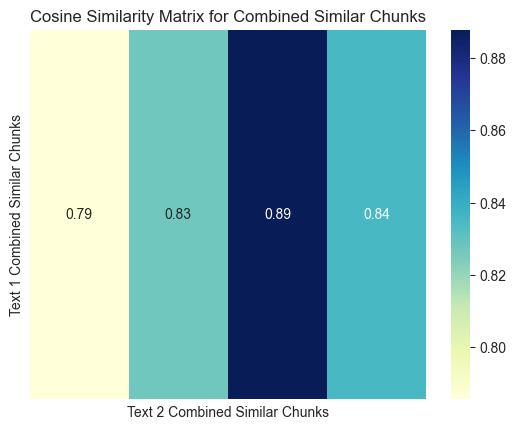

In [41]:
# Print a heatmap of the combined similarity matrix
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(combined_similarity_matrix, annot=True, cmap="YlGnBu", xticklabels=False, yticklabels=False)
plt.title("Cosine Similarity Matrix for Combined Similar Chunks")
plt.xlabel("Text 2 Combined Similar Chunks")
plt.ylabel("Text 1 Combined Similar Chunks")
plt.show()

In [42]:
# Print the most similar pairs of combined similar chunks
most_similar_indices = np.unravel_index(combined_similarity_matrix.argmax(), combined_similarity_matrix.shape)
most_similar_score = combined_similarity_matrix[most_similar_indices]

print(f"Most similar pair of combined similar chunks: {most_similar_indices}, Similarity score: {most_similar_score:.4f}")

Most similar pair of combined similar chunks: (0, 2), Similarity score: 0.8878


In [45]:
# Print the combined similar chunks for the most similar pair
print("Most similar pair of combined similar chunks:")
print(f"\n\nText 1 combined similar chunks: {text_1_similar_texts[most_similar_indices[0]]}")
print(f"\n\nText 2 combined similar chunks: {text_2_similar_texts[most_similar_indices[1]]}")

Most similar pair of combined similar chunks:


Text 1 combined similar chunks: Data availability The authors declare that all data supporting the ﬁndings of this study are available within this article, its Supplementary Information ﬁles, the peer-review ﬁle, or are available from the corresponding author upon reasonable request. Received: 22 November 2018; Accepted: 13 November 2019; References 1. Kroemer, G., Marino, G. & Levine, B. Autophagy and the integrated stress response. Mol. Cell 40, 280–293 (2010). 2. Kumsta, C., Chang, J. T., Schmalz, J. & Hansen, M. Hormetic heat stress and HSF-1 induce autophagy to improve survival and proteostasis in C. elegans. Nat. Commun. 8, 14337 (2017). 3. Hansen, M., Rubinsztein, D. C. & Walker, D. W. Autophagy as a promoter of longevity: insights from model organisms. Nat. Rev. Mol. Cell Biol. 19, 579–593 (2018). 4. Gatica, D., Lahiri, V. & Klionsky, D. J. Cargo recognition and degradation by selective autophagy. Nat. Cell Biol. 20, 233–242 (2018